# Description
This will focus on using classic regression models to model the data, instead of time series methods. 

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
! pip install arviz pystan stan_utility

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 4.3MB 15.6MB/s 
     |████████████████████████████████| 296kB 25.5MB/s 


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    base_path = r'/content/gdrive/My Drive/data_sci/colab/ski/'
    os.chdir(base_path)
    try:
        ! git clone https://github.com/chrisoyer/ski-snow-modeling/
    except:  # if dir not empty e.g. already cloned
        pass
    mod_path = os.path.join(base_path, 
                            r"ski-snow-modeling/src/analysis/project_utils/project_utils.py")
    import importlib.util
    spec = importlib.util.spec_from_file_location(name="utils.name", location=mod_path)
    utils = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(utils)
    
    os.chdir('./ski-snow-modeling/')
    # Change the working directory to the repo root.
    # Add the repo root to the Python path.
    import sys
    sys.path.append(os.getcwd())
else:
    # local running
    import project_utils as utils

Mounted at /content/gdrive
fatal: destination path 'ski-snow-modeling' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import pickle

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
import pystan
import stan_utility

%load_ext autoreload
%autoreload 2

# Parameters

In [4]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [5]:
file_path = r'data/snow_data_clean.parquet'
all_data_path = os.path.join(os.getcwd(), file_path)

In [6]:
# parquet opening is broken on colab
with open(all_data_path, 'rb') as parq_file:
    long_series_df = pd.read_parquet(parq_file)
assert long_series_df.base.isna().sum()==0
month_ts_df = long_series_df.pipe(utils.resample_by_month, time_col='pseudo_ts')
# start analysis with just CO resorts
co_base_ts = (month_ts_df
              .query('state=="colorado"')
              .sort_values(by='pseudo_ts')
              .dropna(how='all')
             )
long_series_df.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,dayofyr,timestamp,base,station,snowfall,ski_yr,state,region,pseudo_ts_delt,pseudo_ski_yr,pseudo_ts,basecol_interpolated
11085,137.0,2016-01-10,0.000000,Mt. Holiday,2.0,5.0,michigan,Other,324.0,-31.0,1692-01-10,True
11086,138.0,2016-01-11,-2.320142,Mt. Holiday,3.0,5.0,michigan,Other,324.0,-31.0,1692-01-11,True
11087,139.0,2016-01-12,-2.320142,Mt. Holiday,5.0,5.0,michigan,Other,324.0,-31.0,1692-01-12,True
11088,140.0,2016-01-13,6.737995,Mt. Holiday,0.0,5.0,michigan,Other,324.0,-31.0,1692-01-13,False
11089,141.0,2016-01-14,10.000000,Mt. Holiday,0.0,5.0,michigan,Other,324.0,-31.0,1692-01-14,False


# Feature Engineering

In [7]:
def add_month(data: pd.DataFrame) -> pd.DataFrame:
    return data.assign(month=lambda x:
                       x.pseudo_ts.dt.month)

def add_diff(data: pd.DataFrame) -> pd.DataFrame:
    return (data
            .assign(delta_base=lambda x: x.base.diff(1))
            .fillna(0)
            .drop(columns=['base'])
           )

def ohe(data: pd.DataFrame, col: str) -> pd.DataFrame:
    return pd.concat([data.drop(columns=[col]),
                      pd.get_dummies(data[col],
                                     prefix=col)],
                     axis=1)

def add_month_x_snowfall(data: pd.DataFrame) -> pd.DataFrame:
    months = [col for col in data.columns
              if 'month_' in col]
    combos_df = pd.concat([pd.Series(data.snowfall * data[month],
                                     name='snowfall_x_' + month)
                           for month in months], axis=1)
    return pd.concat([data, combos_df], axis=1)

def cleaner(data: pd.DataFrame) -> pd.DataFrame:
    """ski_yr is needed for test/train split"""
    data = data.query('basecol_interpolated==True')
    bad_cols = ['dayofyr', 'station', 'state', 'pseudo_ski_yr',
                'timestamp', 'basecol_interpolated', 'pseudo_ts',
                'pseudo_ts_delt'
               ]
    return data.drop(columns=bad_cols)

In [8]:
data = (long_series_df.pipe(add_month)
        .pipe(add_diff)
        #.pipe(ohe, 'region')
        .pipe(ohe, 'month')
        .pipe(add_month_x_snowfall)
        .pipe(cleaner)
)
data.head()

,snowfall,ski_yr,region,delta_base,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,snowfall_x_month_1,snowfall_x_month_2,snowfall_x_month_3,snowfall_x_month_4,snowfall_x_month_5,snowfall_x_month_6,snowfall_x_month_7,snowfall_x_month_8,snowfall_x_month_9,snowfall_x_month_10,snowfall_x_month_11,snowfall_x_month_12
11085,2.0,5.0,Other,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11086,3.0,5.0,Other,-2.320142,1,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11087,5.0,5.0,Other,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31350,0.0,5.0,Other,-1.652098,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31351,0.0,5.0,Other,0.000001,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use regular cross validation.

In [9]:
def split_xy(df: pd.DataFrame) -> (np.array, np.array):
    """splits data into X and y arrays
    drops columns used in train_test_split before this func"""
    df = df.drop(columns=['ski_yr', 'region'])
    return (df.drop(columns=['delta_base']).to_numpy(),
            df.delta_base.to_numpy().reshape(-1))


def train_test_split(data: pd.DataFrame) -> (np.array, np.array, np.array, np.array):
    """splits data
    Output: (X_train, y_train, X_test, y_test)
    """
    train, test = data.query("ski_yr!=8"), data.query("ski_yr==8")
    return (*split_xy(train), *split_xy(test))

In [11]:
def get_results(data: pd.DataFrame, region: str, 
                include_resids: bool=False) -> pd.DataFrame:
    """splits data, trains model for region, and puts results into dataframe
    Arguments:
        data: dataframe with X & y
        region: region to look at
        include_resids: if all y & ŷ instances should be returned inside the dataframe
            WARNING: increases size of df greatly
    Returns: dataframe """
    X_train, y_train, X_test, y_test = train_test_split(data)
    lin_regr = ElasticNetCV(cv=5)
    
    lin_regr.fit(X_train, y_train)
    y_hat_test = lin_regr.predict(X_test)
    lin_resid = y_test - y_hat_test
    results = {}
    results['r2'] = lin_regr.score(X_test, y_test)
    lin_regr_resids = pd.DataFrame(lin_resid)
    results['mse'] = (lin_regr_resids**2).sum()[0]
    results['mae'] = lin_regr_resids.sum().abs()[0]
    results_df = pd.DataFrame(results, index=[region])
    col_list = [c for c in data.columns 
                if c not in ['ski_yr', 'region', 'delta_base']]
    coefs_df = pd.DataFrame(data=lin_regr.coef_.reshape(1,-1), 
                            columns=col_list, index=[region])
    results_df = pd.concat([results_df, coefs_df], axis=1)
    if include_resids:
        results_df['y'] = pd.Series(data=None, dtype='object', name='y')
        results_df['y_hat'] = pd.Series(data=None, dtype='object', name='y_hat')
        results_df.at[region, 'y_hat'] = [y_hat_test]
        results_df.at[region, 'y'] = [y_test]
    return results_df

In [12]:
colo = (get_results(data[data.region=="Colorado"], 'Colorado'))

In [13]:
regional_regression = pd.concat([get_results(data.query("region==@region"), 
                                             region, include_resids=True)
                                 for region in data.region.unique()])

In [14]:
result = regional_regression.drop(columns=['y', 'y_hat']).mean().to_frame().T
result

,r2,mse,mae,snowfall,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,snowfall_x_month_1,snowfall_x_month_2,snowfall_x_month_3,snowfall_x_month_4,snowfall_x_month_5,snowfall_x_month_6,snowfall_x_month_7,snowfall_x_month_8,snowfall_x_month_9,snowfall_x_month_10,snowfall_x_month_11,snowfall_x_month_12
0,0.115945,17167.100144,157.711893,0.003193,0.115638,0.076826,-0.026375,-0.102577,-0.432486,-0.67448,-0.34804,0.065516,0.388345,0.499684,0.125544,-0.100142,-0.056653,0.012345,0.011031,-0.03356,-0.010063,0.0,0.0,0.0,0.0,0.0,0.000276,0.011492


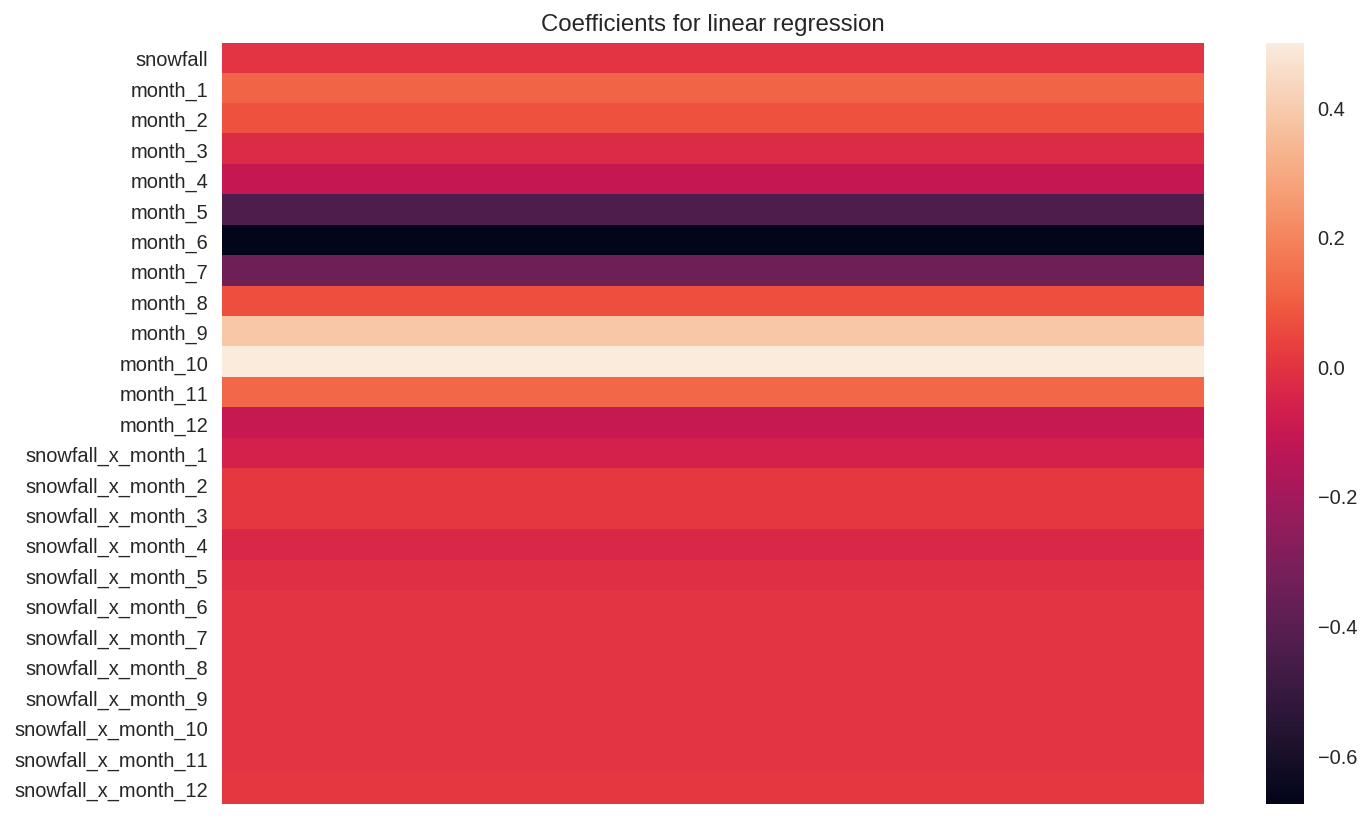

In [39]:
fig, ax = plt.figure(), plt.axes()
sns.heatmap(data=result.drop(columns=['mse', 'mae', 'r2']).T, ax=ax)
plt.title("Coefficients for linear regression")
ax.set_xticklabels("")
plt.show();

We do see lower values for the month labels during summer, but some months seem to "grow" snow without actual snowfall!

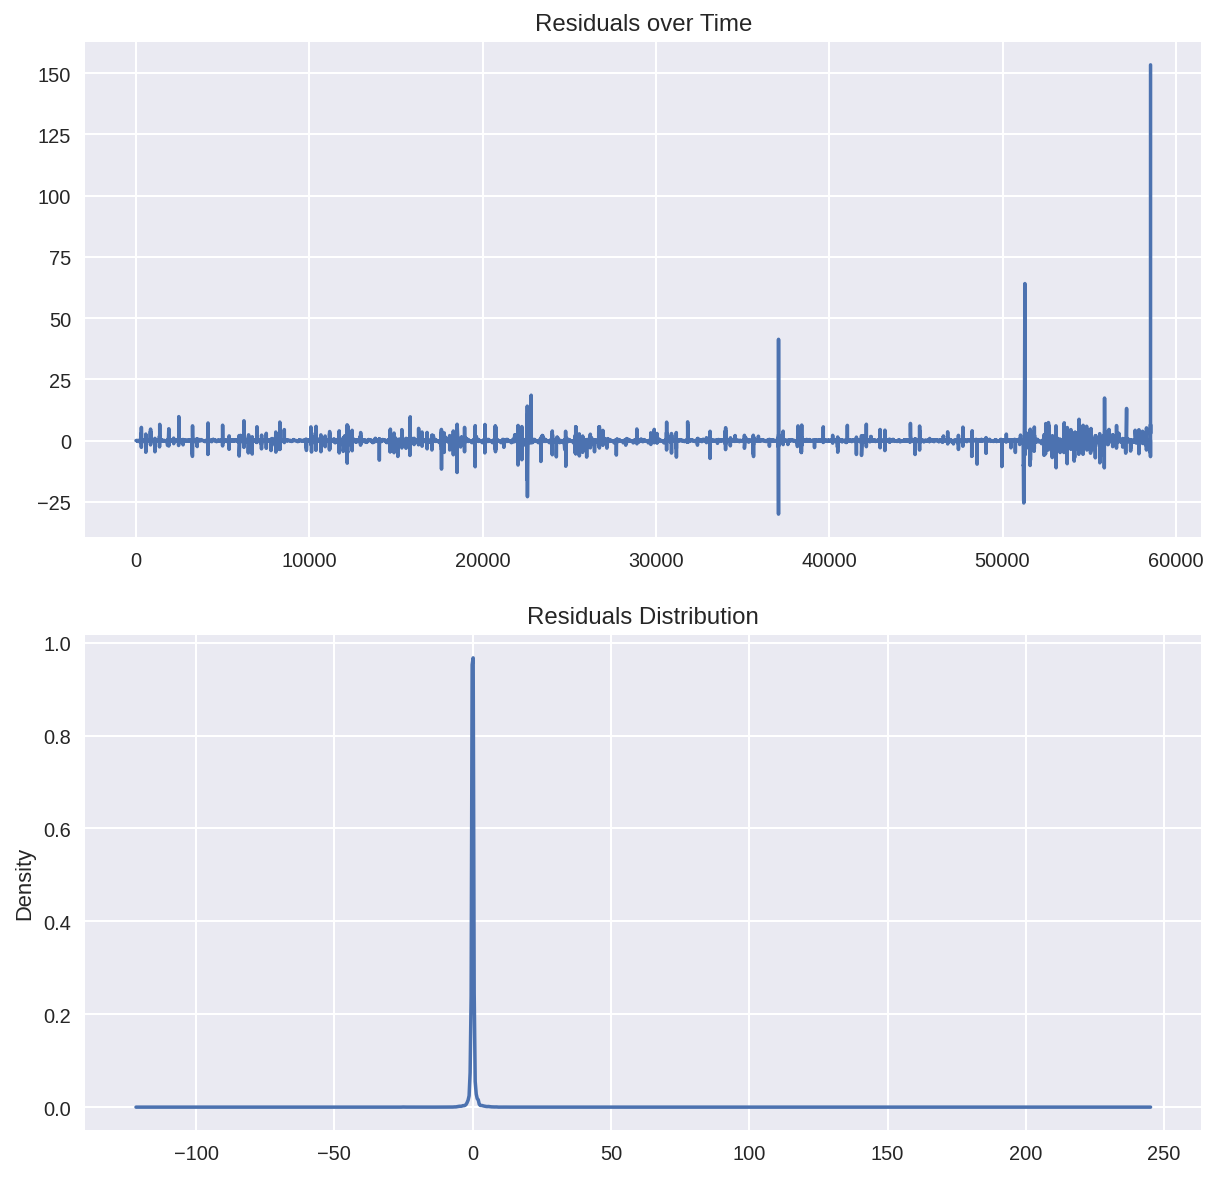

count    58542.000000
mean        -0.008443
std          1.531640
min        -30.035679
25%         -0.165369
50%         -0.015371
75%          0.162994
max        153.372815
dtype: float64


In [40]:
lin_regr_resids = pd.DataFrame()
lin_regr_resids['y']= np.concatenate([y[0] for y in regional_regression.y])
lin_regr_resids['y_hat'] = np.concatenate([yh[0] for yh in regional_regression.y_hat])
utils.resid_plotter(residuals=lin_regr_resids.y_hat-lin_regr_resids.y,
                    y=lin_regr_resids.y)

The betas on the snow and monthly evolution (e.g. melting) are all over the place. I will turn to a baysian model to constrain these.

# Bayesian Linear Model
I want to add priors to the model that snowfall should only result in increases in base depth, and monthly effects should only result in reduction (i.e., monthly effect should measure strength of melting.) A bayesian model allows for this.

In [41]:
stan_df = (long_series_df
           .pipe(add_month)
           .pipe(add_diff)
           .pipe(ohe, 'region')
           .pipe(ohe, 'month')
           # skip: coded in stan // .pipe(add_month_x_snowfall)
           .pipe(cleaner)
            )
columns = stan_df.columns
cols1 = [c for c in columns if "snowfall" not in c]
cols2 = [c for c in columns if c not in cols1]
data = stan_df[cols1 + cols2]
stan_df.head()

,snowfall,ski_yr,delta_base,region_Cascades,region_Colorado,region_East,region_New_England,region_Other,region_Rockies_Other,region_Sierras,region_Utah,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
11085,2.0,5.0,0.000000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11086,3.0,5.0,-2.320142,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11087,5.0,5.0,0.000000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
31350,0.0,5.0,-1.652098,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
31351,0.0,5.0,0.000001,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [42]:
# sample data; half million records => slow mcmc
stan_sample_df = stan_df.sample(frac=.1, axis=0, replace=False)

# provide data including shapes and column type locations to stan
month_cols = [col for col in stan_sample_df.columns if "month" in col]
snow_cols = [col for col in stan_sample_df.columns if "snow" in col]

X = stan_sample_df.drop(columns=['delta_base', 'ski_yr'])
X_month= X[month_cols]
X_snow = X['snowfall']
y = stan_sample_df[['delta_base']]
stan_data = {'N': X.shape[0],
             'K_month': X_month.shape[1],
             'X_month': X_month.to_numpy(),
             'X_snow': X_snow.to_numpy().reshape(-1,1),
             'y': y.to_numpy().reshape(-1),
             }

In [78]:
stan_model_str = """
data {
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictors
    matrix[N, K_month] X_month;   // predictor for melting features
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
}
parameters {
    real alpha;                        // intercept
    vector<upper=0>[K_month] beta_mo;  // coefficients for melting
    vector<lower=0>[1] beta_snow;      // coefficients for snowfall
    real<lower=0> sigma;               // must be +ve
    real<lower=0> sig_snow;            // must be +ve
}
transformed parameters {
    //vector[N] y_hat;
    //y_hat = alpha + (X_month*beta_mo) + (X_snow*beta_snow);
}
model {
    alpha ~ normal(0, 2);
    sigma ~ cauchy(0, 10);                      // half Cauchy
    sig_snow ~ cauchy(0, 10);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_snow) T[,0]; // sample from normal, only -ve
    }
    beta_snow[1] ~ beta(2.2, 3);                // prior on snow columns is beta over [0,1]
    y ~ normal(alpha + (X_month*beta_mo) + (X_snow*beta_snow), sigma);
}
generated quantities{
    //vector[N] log_lik;
    //for (n in 1:N) {
    //    log_lik[n] = normal_lpdf(y[n] | theta[n], sigma[n]);
}
"""

In [79]:
sm = pystan.StanModel(model_code=stan_model_str, model_name='stan_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_f493e4da63987c68e35aab345b7995a7 NOW.


In [80]:
# avoid recompile if possible
with open('./models/stan_model.pkl', 'wb') as f:
    pickle.dump(sm, f)

In [81]:
fit = sm.sampling(data=stan_data, iter=2_000, chains=4, n_jobs=-1,
                  control={'adapt_delta': 0.91 # p accepting posterior draw
                           }, 
                  seed=42, verbose=True)

In [82]:
fit

Inference for Stan model: stan_model_f493e4da63987c68e35aab345b7995a7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
alpha          0.48  5.7e-3   0.06    0.4   0.44   0.47   0.52    0.63    118   1.02
beta_mo[1]    -0.36  6.0e-3   0.09  -0.55  -0.42  -0.35   -0.3   -0.19    226   1.02
beta_mo[2]    -0.23  7.0e-3   0.09  -0.42  -0.29  -0.22  -0.17   -0.06    163   1.02
beta_mo[3]    -0.56  5.9e-3   0.08  -0.74   -0.6  -0.55  -0.51   -0.44    163   1.01
beta_mo[4]    -0.71  5.9e-3   0.07  -0.86  -0.75  -0.69  -0.66   -0.61    128   1.02
beta_mo[5]    -0.99  5.8e-3   0.07  -1.13  -1.02  -0.97  -0.94   -0.89    127   1.02
beta_mo[6]     -1.2  5.9e-3   0.07  -1.35  -1.23  -1.18  -1.15    -1.1    127   1.02
beta_mo[7]    -0.88  5.7e-3   0.06  -1.03  -0.92  -0.87  -0.83   -0.79    126   1.02
beta_mo[8]    -0.48  5.7e-3   0.07  -0.63  -0.52

In [83]:
# for overnight run
result_path = './models/stan_results.pkl'
try:
    fit
except NameError:
    with open(result_path, 'rb') as f:
        pickle.load(fit, f)
else:
    with open(result_path, 'wb') as f:
        pickle.dump(fit, f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  # Remove the CWD from sys.path while we load stuff.


## MCMC Diagnostics
We will want to check:
1. Model actually runs.
1. Good Mixing of Chains: (fix with stronger prior, reparameterization)
    1. $\hat{R}$ is 1.1 or under for all parameters.
    1. When n_eff / n_transitions < 0.001 the estimators that we use are often biased and can significantly overestimate the true effective sample size.
1. Check tree depth:
if threshold saturated, increase tree depth _control={max_treedepth: 15}_
1. 

_



In [87]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
10.0 of 2000 iterations ended with a divergence (0.5%)
  Try running with larger adapt_delta to remove the divergences
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [88]:
stan_utility.utils.check_treedepth(fit)

0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [89]:
stan_utility.utils.check_energy(fit)

E-BFMI indicated no pathological behavior


In [90]:
stan_utility.utils.check_div(fit)

10.0 of 2000 iterations ended with a divergence (0.5%)
  Try running with larger adapt_delta to remove the divergences


In [96]:
fit_df = fit.to_dataframe()
fit_df.mean().to_frame()

,0
chain,1.500000
draw,249.500000
warmup,0.000000
alpha,0.482796
beta_mo[1],-0.358550
beta_mo[2],-0.231350
beta_mo[3],-0.561009
beta_mo[4],-0.706867
beta_mo[5],-0.986643
beta_mo[6],-1.195431


In [99]:
# fix brackets in col nmaes
fit_df = (fit_df.rename(columns=lambda x: x.replace("[", "_"))
          .rename(columns=lambda x: x.replace("]", "")))

fit_df.head()


,chain,draw,warmup,alpha,beta_mo_1,beta_mo_2,beta_mo_3,beta_mo_4,beta_mo_5,beta_mo_6,beta_mo_7,beta_mo_8,beta_mo_9,beta_mo_10,beta_mo_11,beta_mo_12,beta_snow_1,sigma,sig_snow,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,0.460495,-0.384664,-0.260321,-0.501839,-0.683369,-0.974983,-1.129486,-0.858000,-0.450316,-0.164068,-0.034542,-0.422711,-0.822097,0.031311,1.529415,0.708189,-44184.181067,0.954324,0.112333,4,15,0,44191.455739
1,0,1,0,0.464104,-0.318464,-0.124129,-0.577669,-0.691421,-0.986789,-1.149437,-0.854763,-0.456642,-0.164430,-0.033421,-0.463061,-0.839032,0.058245,1.532167,0.909936,-44185.985605,0.884347,0.112333,5,31,0,44191.779397
2,0,2,0,0.445219,-0.268777,-0.211401,-0.533737,-0.686700,-0.950677,-1.150701,-0.852579,-0.452492,-0.168860,-0.016876,-0.450357,-0.850037,0.061842,1.541141,0.684066,-44187.559071,0.831117,0.112333,4,31,0,44197.962708
3,0,3,0,0.441292,-0.279708,-0.204194,-0.526458,-0.680436,-0.947953,-1.153829,-0.844341,-0.453601,-0.170537,-0.015691,-0.442736,-0.845724,0.055573,1.542614,0.672196,-44187.951206,0.975203,0.112333,4,31,0,44195.907042
4,0,4,0,0.430471,-0.394120,-0.171925,-0.513843,-0.649344,-0.931942,-1.144810,-0.862752,-0.443715,-0.131844,-0.022611,-0.377516,-0.753713,0.022925,1.519194,0.512074,-44189.453973,0.980076,0.112333,5,31,0,44195.805273


## Visualization of results

In [ ]:
az_data = az.from_pystan(
    posterior=fit,
    posterior_predictive="y_hat",
    observed_data=["y"],
    log_likelihood={"y": "log_lik"},
    coords={"school": np.arange(eight_school_data["J"])},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)


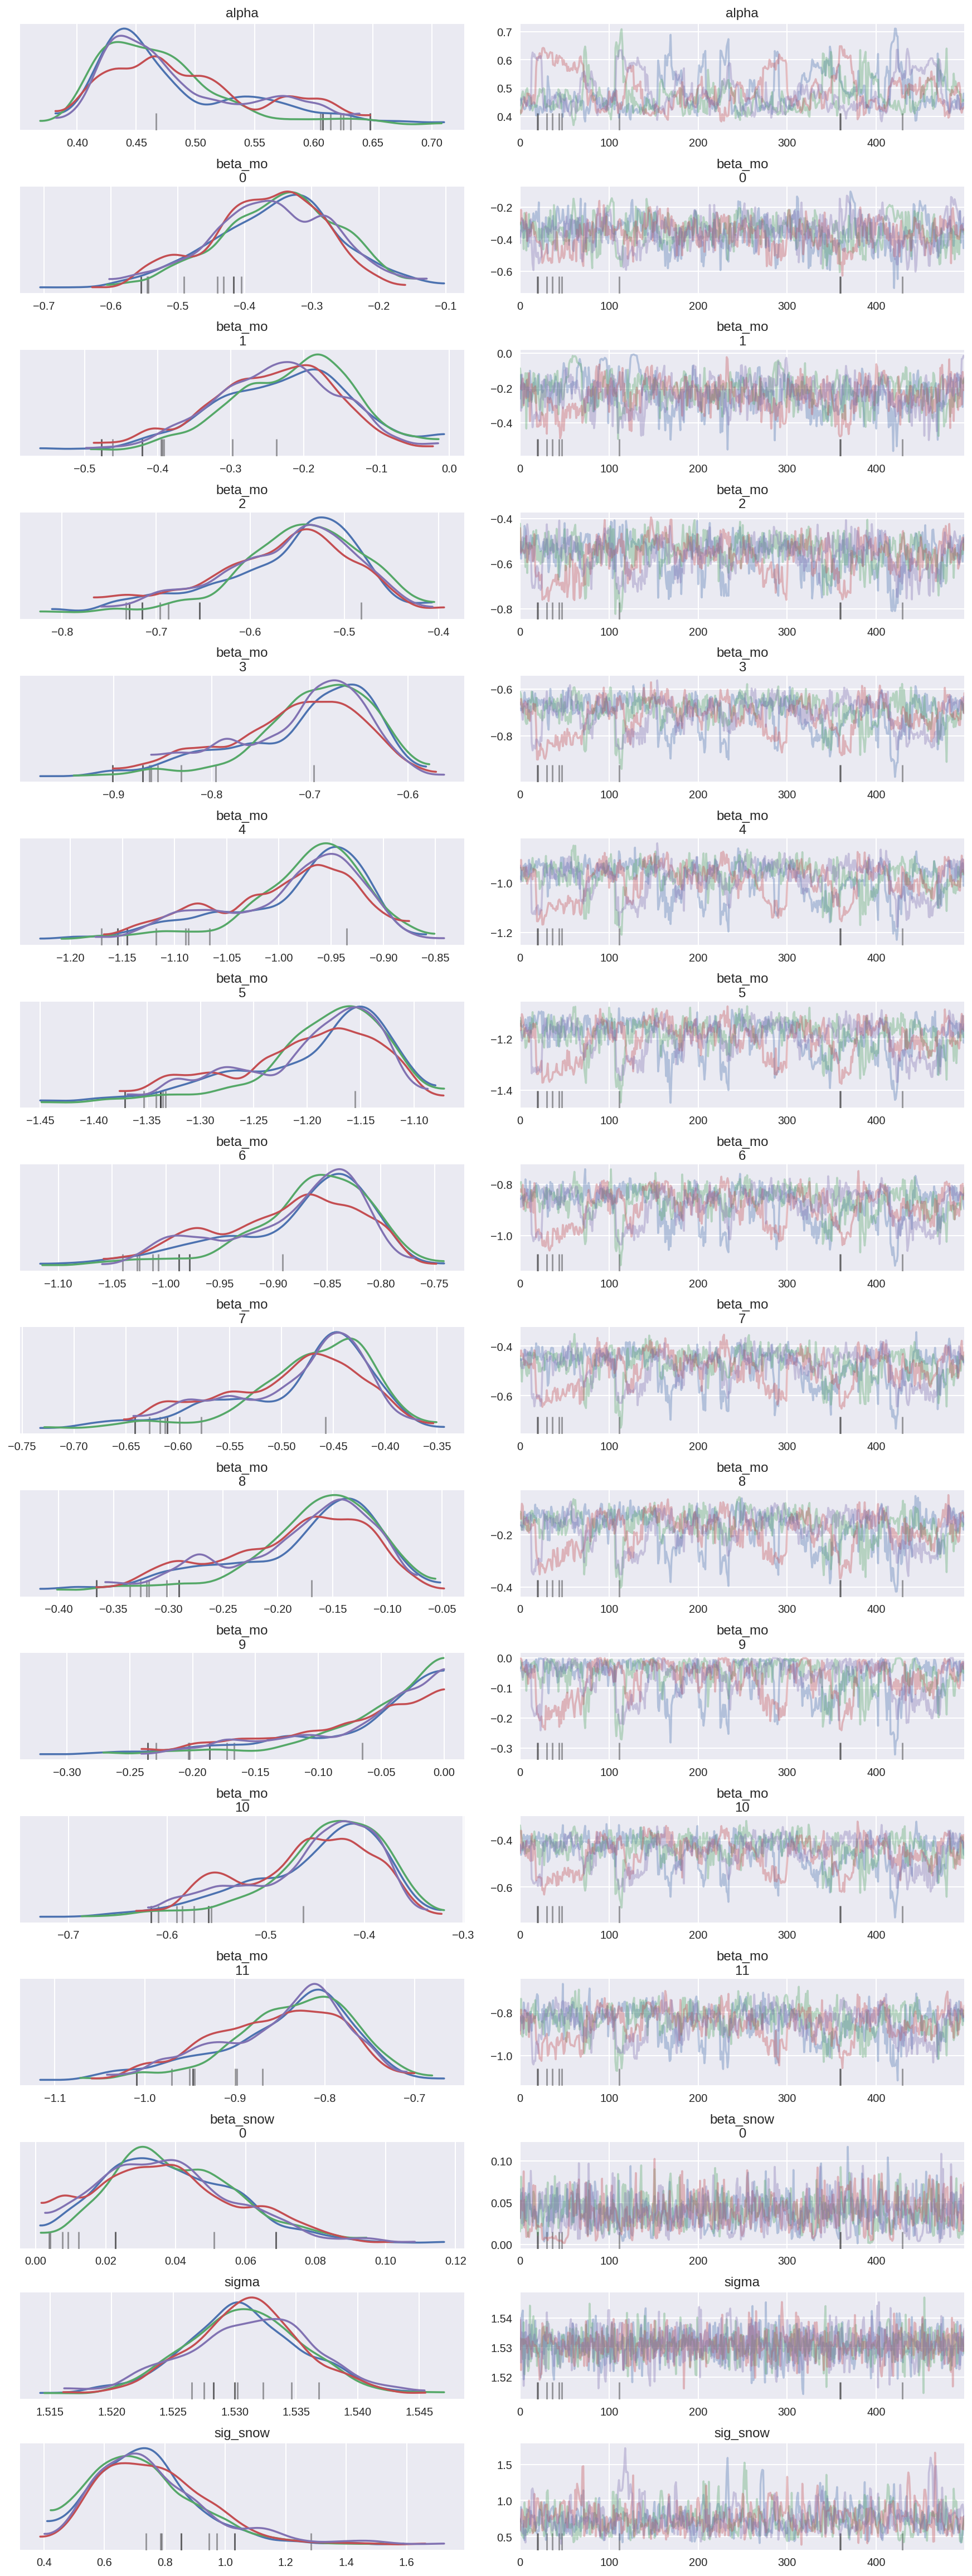

In [102]:
az.plot_trace(fit);

In [103]:
az.plot_joint(fit, kind='kde', fill_last=False);

/usr/local/lib/python3.6/dist-packages/arviz/plots/jointplot.py:149: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


Exception: ignored